In [1]:
# Add the genderComputer library to the path
import os
import pandas as pd
import sys

path = os.path.join(os.getcwd(), 'vendor', 'genderComputer')
sys.path.insert(0, path)

In [2]:
# Infer the gender of the authors
import analyze_genders

df = analyze_genders.dataframe(field='DB', exclude=['PODS'])
aggregates = analyze_genders.aggregate_authorship(df)

In [3]:
# Ratio of male to female (known)
known_gender = df[~df['unknown'] & ~df['unisex']]
print(known_gender[known_gender['female']]['author_id'].nunique() / known_gender['author_id'].nunique())

# Ratio of male to female (assumed)
unknown_gender = df[df['unknown'] | df['unisex']]
print(unknown_gender[unknown_gender['female']]['author_id'].nunique() / unknown_gender['author_id'].nunique())

0.2348603702541575
0.22760969745541976


In [4]:
df.groupby(['conf']).agg({'year': ['min', 'max'], 'paper_id': pd.Series.nunique, 'author_id': pd.Series.nunique})

year       paper_id author_id
         min   max  nunique   nunique
conf                                 
CIDR    2003  2019      427      1043
DASFAA  2001  2019     1457      3433
DKE     1985  2020     1719      3440
EDBT    1988  2020     1575      3328
ICDE    1984  2020     4764      8050
SIGMOD  1975  2020     4111      6968
VLDB    1975  2020     5226      8636
VLDBJ   1992  2020      892      1960

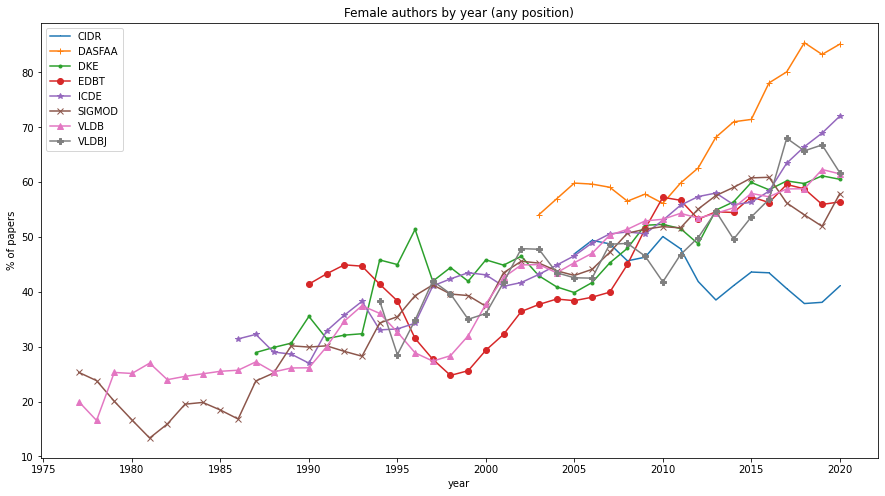

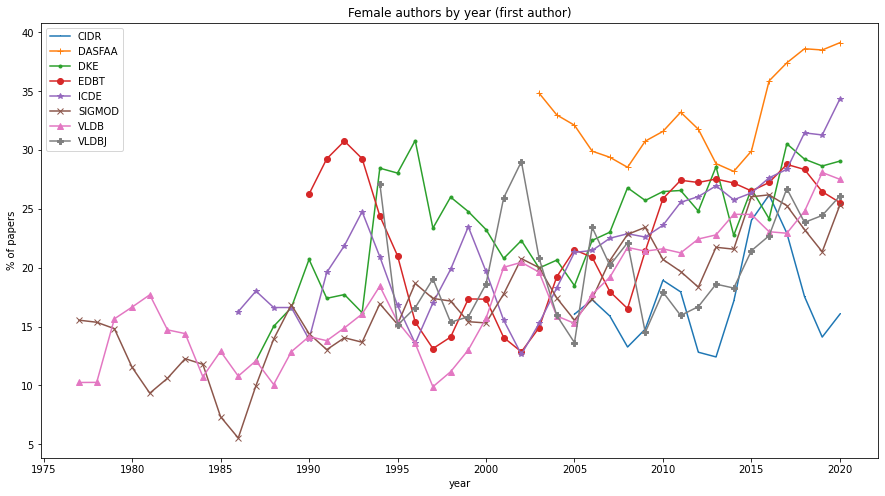

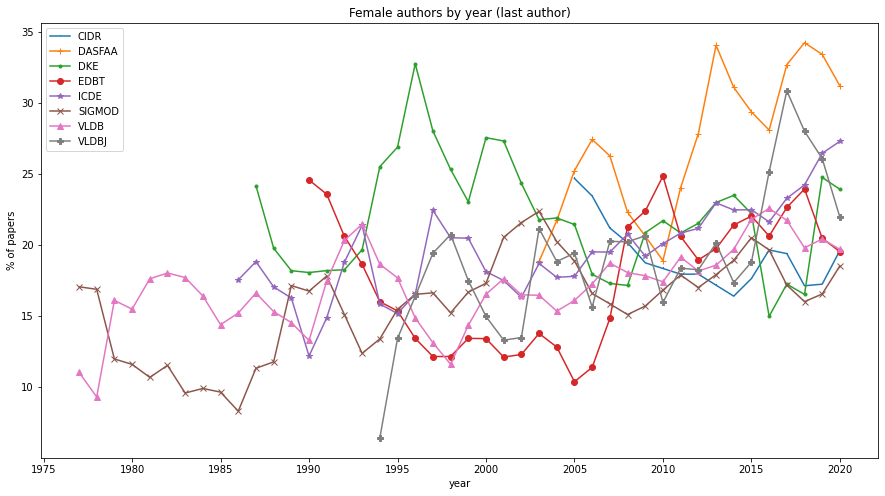

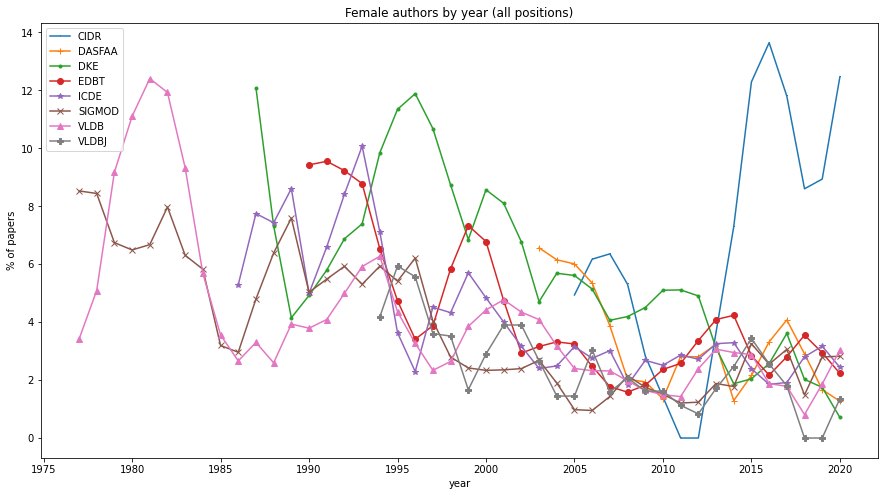

In [5]:
analyze_genders.plot_authors(aggregates['any'], 'any position')
analyze_genders.plot_authors(aggregates['first'], 'first author')
analyze_genders.plot_authors(aggregates['last'], 'last author')
analyze_genders.plot_authors(aggregates['all'], 'all positions')

In [6]:
df.loc[df['unknown'] | df['unisex'], ' male'] = False

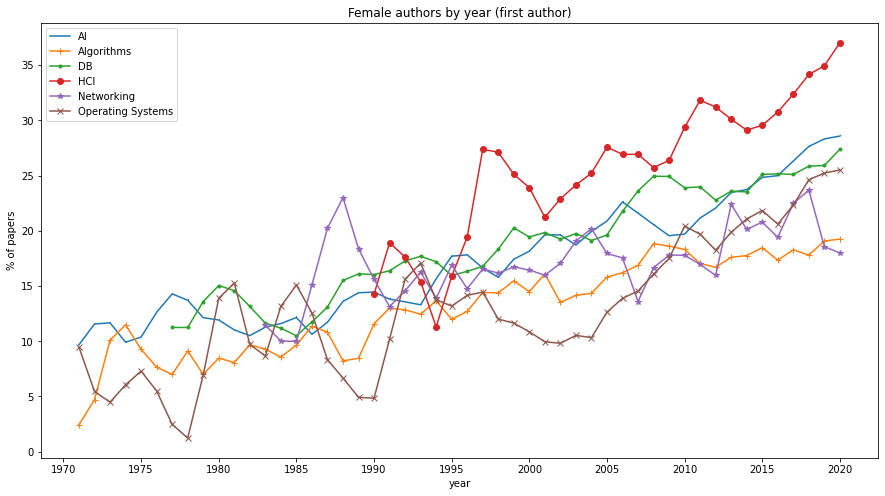

In [7]:
df = analyze_genders.dataframe(exclude=['CIDR', 'DASFAA', 'DKE', 'EDBT'])
aggregates = analyze_genders.aggregate_authorship(df, group_attrs=['field', 'year'], funcs={'first': analyze_genders._first_female_author})
analyze_genders.plot_authors(aggregates['first'], 'first author')

In [8]:
# Get the average number of papers
# (equivalent to the average last author index per paper)
df.drop_duplicates(subset=['paper_id']).groupby(['field']).agg({'author_position_last': 'mean'})

,author_position_last
field,
AI,3.046212
Algorithms,2.469664
DB,3.471101
HCI,3.991605
Networking,4.217273
Operating Systems,4.268136
